In [10]:
from src.vae import VAE, VaeDecoderMnist, VaeEncoderMnist

import numpy as np

import torch

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
dataset = datasets.MNIST(
    root='../../data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [4]:
latent_dim = 2

model = VAE(
    encoder=VaeEncoderMnist(latent_dim),
    decoder=VaeDecoderMnist(latent_dim)
)

Load pre-trained VAE model for MNIST.

In [5]:
state_dict = torch.load('../../models/mnist_vae.pth', map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
del state_dict

Two main ways to visualize the latent space of a VAE are:
1. Visualizing the latent space by scatter plot.
2. Visualizing the latent space by generating images from the latent space.

In [6]:
def sample_plot_latent_space(model: VAE,
                             digit_size: int = 28, num_points: int = 25,
                             min_x: float = -3, max_x: float = 3, min_y: float = -3, max_y: float = 3):
    figure = np.zeros((digit_size * num_points, digit_size * num_points))

    grid_x = np.linspace(min_x, max_x, num_points)
    grid_y = np.linspace(min_y, max_y, num_points)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure_rows = slice(i * digit_size, (i + 1) * digit_size)
            figure_cols = slice(j * digit_size, (j + 1) * digit_size)
            figure[figure_rows, figure_cols] = digit.detach().numpy()

    plt.figure(figsize=(15, 15))
    plt.title("VAE latent space")

    start_range = digit_size // 2
    end_range = num_points * digit_size + start_range

    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)

    plt.xlabel("$z_0$")
    plt.ylabel("$z_1$")

    plt.imshow(figure, cmap='Greys_r')
    plt.tight_layout()

In [7]:
def scatter_plot_latent_space(model: VAE, dataset: torch.utils.data.Dataset):
    z = []
    labels = []

    for i in range(len(dataset)):
        x, y = dataset[i]
        mu, logvar = model.encoder(x)
        z.append(mu.detach().numpy()[0])
        labels.append(y)

    z = np.array(z)
    print(z.shape)
    labels = np.array(labels)

    plt.figure(figsize=(10, 10))
    points = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.legend(*points.legend_elements())

    plt.title("VAE latent space")
    plt.tight_layout()

(10000, 2)


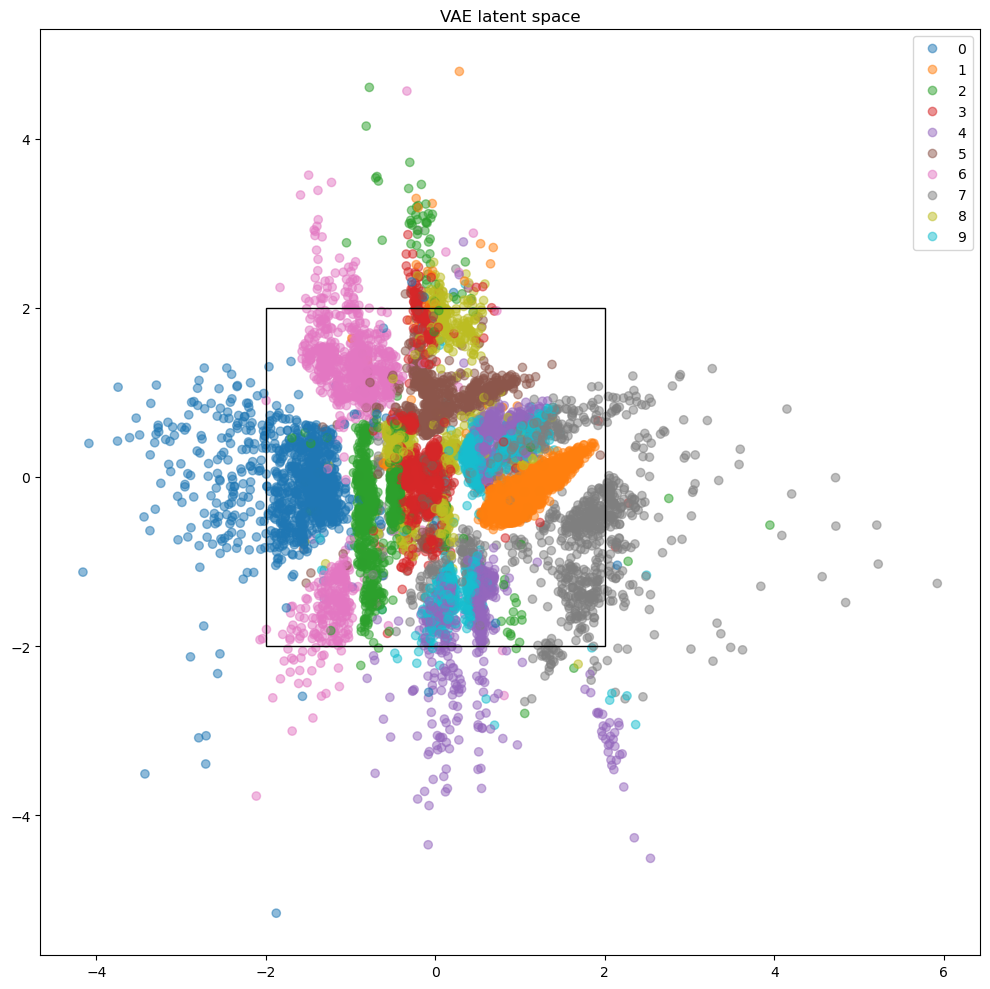

In [14]:
scatter_plot_latent_space(model, dataset)
# plot [-2, 2] x [-2, 2] rectangle
plt.gca().add_patch(Rectangle((-2, -2), 4, 4, linewidth=1, edgecolor='black', facecolor='none'))
plt.savefig('../../resources/vae/vae_latent_space_scatter.png', transparent=True)

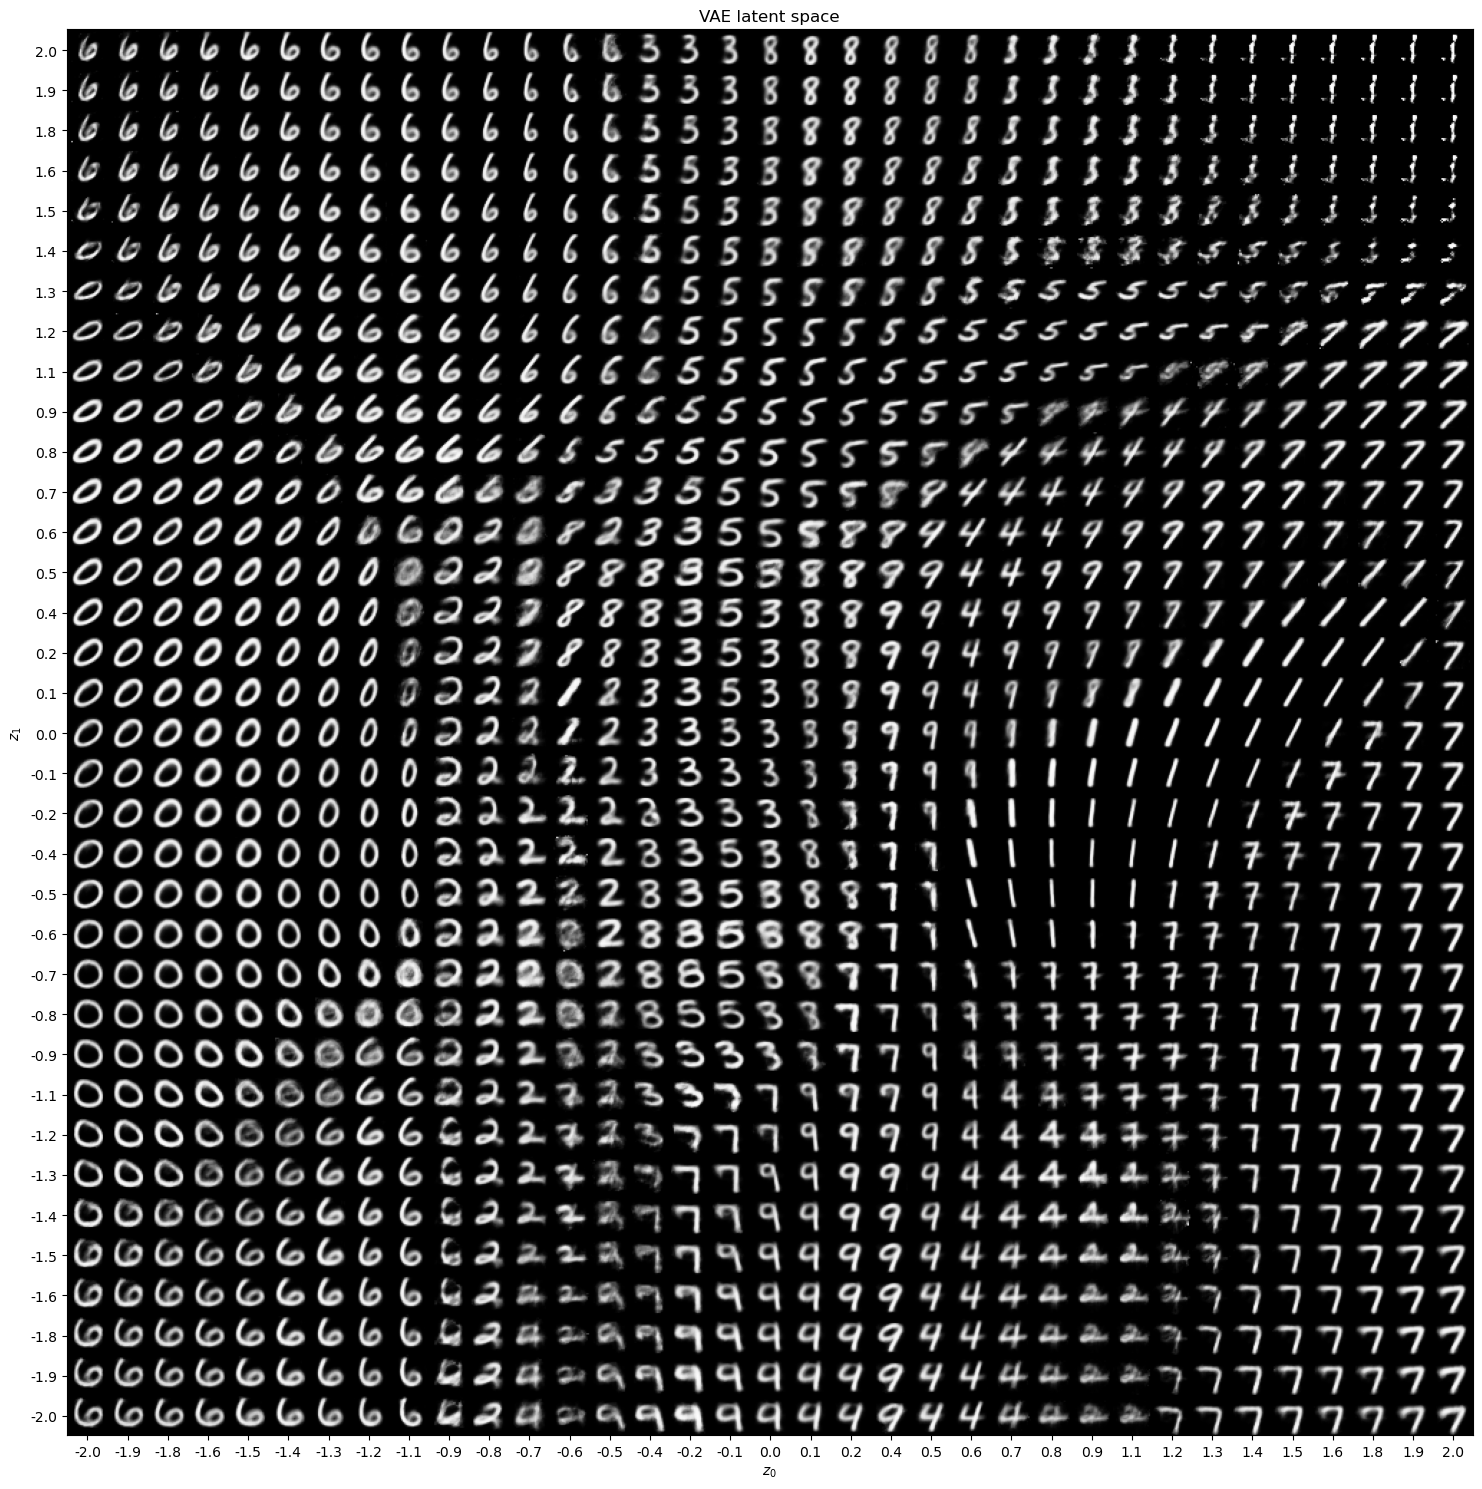

In [17]:
sample_plot_latent_space(model, min_x=-2, min_y=-2, max_x=2, max_y=2, num_points=35)
plt.savefig('../../resources/vae/vae_latent_space_sample.png', transparent=True)

Also we now can use latent representation to interpolate between two samples.

In [9]:
X, y = dataset.data.reshape(-1, 28 * 28).float() / 255, dataset.targets

In [10]:
# pick sample of 1 and 2
sample_1 = X[y == 1][0]
sample_2 = X[y == 2][0]

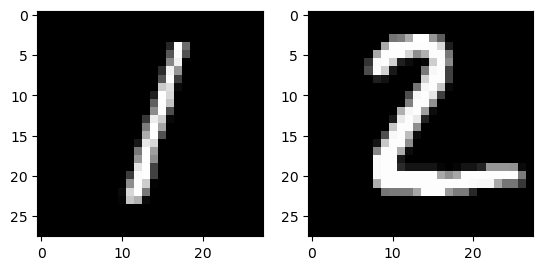

In [11]:
plt.subplot(1, 2, 1)
plt.imshow(sample_1.reshape(28, 28), cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(sample_2.reshape(28, 28), cmap='gray')

In [12]:
mu_1, logvar_1 = model.encoder(sample_1.unsqueeze(0))
mu_2, logvar_2 = model.encoder(sample_2.unsqueeze(0))

In [13]:
def interpolate(model: VAE, mu_1: torch.Tensor, mu_2: torch.Tensor, num_steps: int = 10):
    z = torch.zeros((num_steps, mu_1.shape[1]))

    for i in range(num_steps):
        z[i] = mu_1 + (mu_2 - mu_1) * i / (num_steps - 1)

    x = model.decoder(z)
    return x

In [14]:
def plot_interpolation(interpolation: torch.Tensor):
    fig = plt.figure(figsize=(15, 15))
    num_steps = interpolation.shape[0]
    image = np.zeros((28, 28 * num_steps))

    for i in range(num_steps):
        image[:, i * 28: (i + 1) * 28] = interpolation[i].reshape(28, 28).detach().numpy()

    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [15]:
interpolation = interpolate(model, mu_1, mu_2, num_steps=100)

In [16]:
plot_interpolation(interpolation)

In [17]:
# Create a gif of the interpolation
import imageio

save_path = '../../resources/results/interpolation.gif'

images = interpolation.detach().numpy().reshape(-1, 28, 28)
images = (images * 255).astype(np.uint8)

imageio.mimsave(save_path, images, fps=100)